# 神经网络

## 1. 概述

使用torch.nn包构建神经网络

nn依赖于autograd来定义模型并对其进行微分

nn.Module包含层，以及返回output的方法forward(input)

以下是对数字图像进行分类的网络：

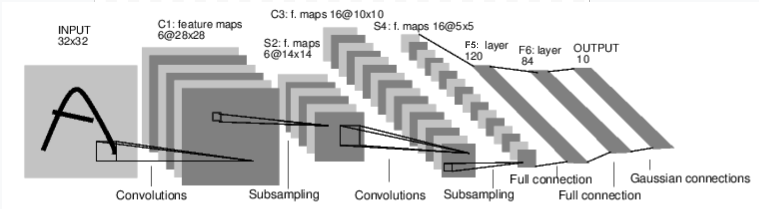

这是一个简单的前馈网络。 它获取输入，将其一层又一层地馈入，然后最终给出输出

神经网络的典型训练过程如下：
- 定义具有一些可学习参数（或权重）的神经网络
- 遍历输入数据集
- 通过网络处理输入
- 计算损失（输出正确的距离有多远）
- 将梯度传播回网络参数
- 通常使用简单的更新规则来更新网络的权重：weight = weight - learning_rate * gradient

## 2. 定义网络

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
print(net)


Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


只需要定义forward函数，就可以使用autograd为您自动定义backward函数（计算梯度）。 您可以在forward函数中使用任何张量操作

模型的可学习参数由net.parameters()返回

In [4]:
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight


10
torch.Size([6, 1, 5, 5])


尝试一个32x32随机输入

In [5]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)


tensor([[-0.1018, -0.0654, -0.0099, -0.1096,  0.0989,  0.0375, -0.0659, -0.1187,
          0.0098, -0.0196]], grad_fn=<AddmmBackward0>)


使用随机梯度将所有参数和反向传播的梯度缓冲区归零：

In [6]:
net.zero_grad()
out.backward(torch.randn(1, 10))


注意：

torch.nn仅支持小批量。 整个torch.nn包仅支持作为微型样本而不是单个样本的输入

例如，nn.Conv2d将采用nSamples x nChannels x Height x Width的 4D 张量

如果您只有一个样本，只需使用input.unsqueeze(0)添加一个假批量尺寸


回顾：

- torch.Tensor-一个多维数组，支持诸如backward()的自动微分操作。 同样，保持相对于张量的梯度
- nn.Module-神经网络模块。 封装参数的便捷方法，并带有将其移动到 GPU，导出，加载等的帮助器
- nn.Parameter-一种张量，即将其分配为Module的属性时，自动注册为参数
- autograd.Function-实现自动微分操作的正向和反向定义。 每个Tensor操作都会创建至少一个Function节点，该节点连接到创建Tensor的函数，并且编码其历史记录

## 3. 损失函数

损失函数采用一对（输出，目标）输入，并计算一个值，该值估计输出与目标之间的距离

nn包下有几种不同的损失函数。 一个简单的损失是：nn.MSELoss，它计算输入和目标之间的均方误差

In [7]:
output = net(input)
target = torch.randn(10)  # a dummy target, for example
target = target.view(1, -1)  # make it the same shape as output
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)


tensor(1.6757, grad_fn=<MseLossBackward0>)


现在，如果使用.grad_fn属性向后跟随loss，将看到一个计算图，如下所示：

input -> conv2d -> relu -> maxpool2d -> conv2d -> relu -> maxpool2d
      -> view -> linear -> relu -> linear -> relu -> linear
      -> MSELoss
      -> loss


因此，当我们调用loss.backward()时，整个图将被微分。 损失，并且图中具有requires_grad=True的所有张量将随梯度累积其.grad张量。

为了说明，让我们向后走几步：

In [9]:
print(loss.grad_fn)  # MSELoss
print(loss.grad_fn.next_functions[0][0])  # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # ReLU


## 4. 反向传播

要反向传播误差，我们要做的只是对loss.backward()。不过，需要清除现有的梯度，否则梯度将累积到现有的梯度中

现在，我们将其称为loss.backward()，然后看一下向后前后conv1的偏差梯度

In [10]:
net.zero_grad()     # zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)


conv1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0.])
conv1.bias.grad after backward
tensor([-0.0035,  0.0012,  0.0138, -0.0118, -0.0069, -0.0126])


## 5. 更新权重

实践中使用的最简单的更新规则是随机梯度下降（SGD）：

weight = weight - learning_rate * gradient

In [11]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()    # Does the update


注意：使用optimizer.zero_grad()将梯度缓冲区手动设置为零。 这是因为如反向传播部分中所述累积了梯度

## 6.参考资料

[PyTorch中文文档——神经网络](https://pytorch.apachecn.org/#/docs/1.7/05)